In [1]:
#importing packages
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML
# import pickle

C:\Users\navin.rawther\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\navin.rawther\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


No. of car images: 8792
No. of non-vehicle images: 8968


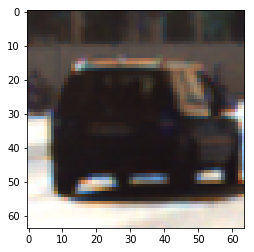

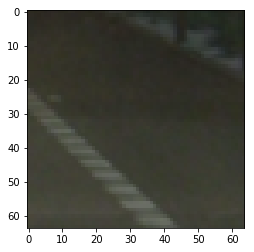

In [2]:
#Read in car image file name
cars=glob.glob('Data/vehicles/vehicles/*/*.png')
# cars=glob.glob('Data/vehicles/vehicles/KITTI_extracted/*.png')

print('No. of car images:',len(cars))

#Read in non-car image file names
not_cars=glob.glob('Data/non-vehicles/non-vehicles/*/*.png')
# not_cars=glob.glob('Data/non-vehicles/non-vehicles/Extras/*.png')

print('No. of non-vehicle images:',len(not_cars))

rand_index_car = np.random.randint(0, len(cars))
rand_index_not_car = np.random.randint(0, len(not_cars))

car_img=cv2.imread(cars[rand_index_car])
not_car_img=cv2.imread(not_cars[rand_index_not_car])

plt.imshow(car_img)
plt.show()
plt.imshow(not_car_img)
plt.show()

In [42]:
# Function to return HOG features and visualization (if vis==True)
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    # Return with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise Return with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [4]:
# Function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Create the feature vector by resizing it and flattening it
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Computing the histogram of the color channels separately
    c1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    c2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    c3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenating the histograms into a single feature vector
    hist_features = np.concatenate((c1_hist[0], c2_hist[0], c3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
def extract_features(imgs, cspace, spatial_size, hist_bins, hist_range, orient, pix_per_cell, cell_per_block, hog_channel):
    
    # List to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)   
            
        # Get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Get color space histogram
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Get the HOG fetures
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the feature vectors to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        
    # Return list of feature vectors
    return features

In [6]:
spatial = 32
histbin = 64
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'   # Can be 0, 1, 2, or "ALL"
hist_range=(0, 256)


car_features = extract_features(cars, colorspace, (spatial, spatial), histbin, (0, 256), orient, pix_per_cell, cell_per_block, hog_channel)
not_car_features = extract_features(not_cars, colorspace, (spatial, spatial), histbin, (0, 256), orient, pix_per_cell, cell_per_block, hog_channel )

In [65]:
print(len(car_features[0]))
print(len(not_car_features[0]))

8556
8556


In [119]:
# Create an array stack of feature vectors
X = np.vstack((car_features, not_car_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [120]:
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

KeyboardInterrupt: 

In [ ]:
# Use a SVC 
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = SVC()
# clf = GridSearchCV(svc, parameters)
# clf.fit(X_train, y_train)
# best_clf = clf.best_estimator_

# print(best_clf)

# pred = best_clf.predict(X_test)

svc.fit(X_train, y_train)

pred=svc.predict(X_test)
print('Test Accuracy:',accuracy_score(pred,y_test))

In [17]:
# import pickle
# # save the classifier
# with open('my_dumped_classifier.pkl', 'wb') as fid:
#     pickle.dump(svc, fid) 

In [121]:
def slide_window(img, x_start_stop, y_start_stop, xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = 1 + np.int((xspan-xy_window[0])/nx_pix_per_step) 
    ny_windows = 1+ np.int((yspan-xy_window[1])/ny_pix_per_step)
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
#             cv2.rectangle(img, (startx, starty), (endx, endy), (255,0,0), 6)
#     # Return the list of windows
#     plt.show()
    return window_list

In [122]:
def single_img_features(image, cspace, spatial_size, hist_bins, hist_range, orient, pix_per_cell, cell_per_block, hog_channel):
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image)   

    # Get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)

    # Get color space histogram
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    # Get the HOG fetures
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(get_hog_features(feature_image[:,:,channel],orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))      
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True)
        
        # Append the feature vectors to the features list
#         features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return np.concatenate((spatial_features, hist_features,hog_features))

In [123]:
def search_windows(img, windows, clf, scaler, color_space, spatial_size, hist_bins, hist_range, orient, 
                    pix_per_cell, cell_per_block, hog_channel, spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))   
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space, spatial_size, hist_bins, hist_range, orient, 
                                       pix_per_cell, cell_per_block, hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        plt.show()
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [124]:
def draw_boxes(img, bboxes):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
#     i=1
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
#         if i%2==0:
        cv2.rectangle(imcopy, bbox[0], bbox[1], (255,0,0), 6)
#         else:
#             cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), 6)
#         i+=1
    # Return the image copy with boxes drawn
    return imcopy

In [126]:
image=mpimg.imread('test_images/test6.jpg')

ystart = 320
ystop = 656
xstart = 0
xstop = image.shape[1]
spatial_size = (32,32)
hist_bins = 64
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
hist_range=(0, 256)
xy_window=(96, 96)
xy_overlap=(0.5, 0.5)
color_space = 'HSV'

windows = slide_window(image, (xstart,xstop),(ystart,ystop), xy_window, xy_overlap)

hot_windows = search_windows(image, windows, svc, X_scaler, color_space, spatial_size, hist_bins, hist_range, orient, 
                             pix_per_cell, cell_per_block, hog_channel, spatial_feat=True, hist_feat=True, hog_feat=True) 

print(hot_windows)

draw_image = np.copy(image)

window_img = draw_boxes(draw_image, hot_windows) 

plt.imshow(window_img)
plt.show()

ValueError: operands could not be broadcast together with shapes (1,5028) (8556,) (1,5028) 

In [10]:
# heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



In [11]:
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(window_img), labels)

fig = plt.figure(figsize=(24, 9))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

NameError: name 'heat' is not defined

In [17]:
def car_find_pipeline(image):
    
    ystart = 300
    ystop = 656
    scale = 2
    spatial_size = 32
    histbin = 64
    # colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    # hog_channel = 0   # Can be 0, 1, 2, or ALL"
    hist_range=(0, 256)

    out_img,box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size,spatial_size), histbin)
    
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

#     # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [18]:
# heat = np.zeros_like(out_img[:,:,0]).astype(np.float)

#Define the output video location
project_out = 'output_videos/project_video_out.mp4'

#Input video
clip1 = VideoFileClip("project_video.mp4")

#Process frames from the video and save it
white_clip = clip1.fl_image(car_find_pipeline)
%time white_clip.write_videofile(project_out, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_out.mp4
[MoviePy] Writing video output_videos/project_video_out.mp4


  0%|▎                                                                              | 5/1261 [00:23<1:36:54,  4.63s/it]

KeyboardInterrupt: 

In [104]:
#Sliding Window
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = np.copy(img)#cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2RGB)#cv2.COLOR_RGB2YCrCb)
    ctrans_tosearch=cv2.cvtColor(img_tosearch,cv2.COLOR_RGB2HSV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list=[]
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            combined_feature=np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(combined_feature)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                
    return draw_img,box_list

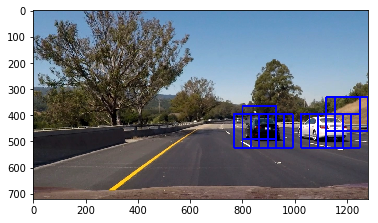

In [105]:
ystart = 300
ystop = 656
scale = 2
spatial_size = 32
histbin = 64
orient = 9
pix_per_cell = 8
cell_per_block = 2
# hog_channel = 0   # Can be 0, 1, 2, or ALL"
hist_range=(0, 256)

img=mpimg.imread('test_images/test6.jpg')

out_img,box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size,spatial_size), histbin)

plt.imshow(out_img)